In [1]:
# Set the display width to max
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Without Dataformat Line


 SharedHits/NormalizedCharge
<class 'pandas.core.frame.DataFrame'>
Int64Index: 93430 entries, 0 to 93429
Columns: 406 entries, pixel_78 to pixel_148
dtypes: float64(404), int32(1), int64(1)
memory usage: 289.8 MB
None

Train on 2366 samples, validate on 263 samples
Epoch 1/100
2366/2366 [==============================] - 8s 3ms/step - loss: 0.5686 - acc: 0.7067 - val_loss: 0.5413 - val_acc: 0.7719
Epoch 2/100
2366/2366 [==============================] - 7s 3ms/step - loss: 0.5075 - acc: 0.7489 - val_loss: 0.5083 - val_acc: 0.8099
Epoch 3/100
2366/2366 [==============================] - 7s 3ms/step - loss: 0.4600 - acc: 0.7743 - val_loss: 0.4473 - val_acc: 0.8061
Epoch 4/100
2366/2366 [==============================] - 7s 3ms/step - loss: 0.4328 - acc: 0.7849 - val_loss: 0.4443 - val_acc: 0.8137
Epoch 5/100
2366/2366 [==============================] - 7s 3ms/step - loss: 0.4238 - acc: 0.7946 - val_loss: 0.4283 - val_acc: 0.8061
Epoch 6/100
2366/2366 [==============================] - 7

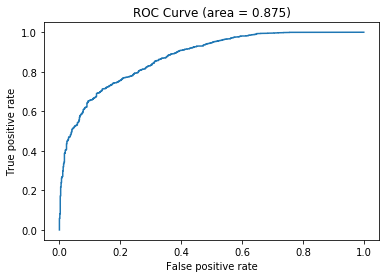

In [6]:
## Import Libraries ##
import keras
from keras.layers import Dense, Dropout, Activation
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from IPython.display import FileLink, FileLinks
import matplotlib.pyplot as plt
import pandas as pd
import sys
import pylab
from scipy.stats.stats import pearsonr

## List data files ##
datafilenames = ["Shared100NonShared/NormalizedCharge/output_final_1.h5","Shared100NonShared/AbsoluteCharge/output_final_1.h5",
                 "SharedHits/NormalizedCharge/output_final_1.h5","SharedHits/AbsoluteCharge/output_final_1.h5",
                "AllHits/NormalizedCharge/output_final_1.h5","AllHits/AbsoluteCharge/output_final_1.h5"]

## One image has 20x20 pixels = 400 pixels ##
pixels = ["pixel_{0}".format(i) for i in range(20*20)]
def to_image(df):
    return  np.expand_dims(np.expand_dims(df[pixels], axis=-1).reshape(-1,20,20), axis=-1)

## Import the data ##

datafilename = datafilenames[2]

df = pd.read_hdf("/uscms_data/d3/bbonham/TrackingDstar/LambaAnalyzer/output_of_postprocess/"+datafilename, key="df", mode='r')
print '\n \033[1m' + datafilename[:-18] + '\033[0m' # file name printed in bold
print df.info()
print ""

## Last cuts and selections. Eventually this should be moved to the postprocessor. ##
df = df[(df["GenDeltaR"]<0.1) & (df["nUniqueSimTracksInSharedHit"]>-1)] # this gets rid of shared hits as well

# Data set before removing single pixel events
df_old = df
df_old_train=df.sample(frac=0.5)
df_old_test=df.drop(df_old_train.index)
images_old_train = to_image(df_old_train)
images_old_test = to_image(df_old_test)

# Removing events that have single pixel
pixelColumns = ["pixel_%i" % x for x in range(400)]
pixels_df = df[pixelColumns].values
# This printout is a sanity check, there 400 pixels so we expect pixels_df to have 400 columns
#print(pixels_df[0].shape)
pixel_number = pixels_df.astype(bool).sum(axis=1)
df.insert(0, "Pixel_number", pixel_number)
# the df.info() printouts allows us to see how many events were removed.
#print df.info()
df = df[df["Pixel_number"]>1]
#print df.info()

## frac=0.5 sets half training and half testing ##
df_train = df.sample(frac=0.5)
df_test = df.drop(df_train.index)
images_train = to_image(df_train)
images_test = to_image(df_test)

## This is the CNN ##
# Adding layers to Neural Network: (1) is convolutional,(1.5) 2D layer ,(2) flatten output then feed it to (3) which is a regular neural network.
# (4) drops nodes in NN to avoid overfitting, finallly (5) outputs 2 values (prob(notmergedhit), prob(merged hit)), must add up to 1.

# Define the network
model = keras.models.Sequential()

# layer (1) you can play with these layers individually or together until you find the best combination
# Here at fnal you have to add input_shape and data_format in the first layer
model.add(keras.layers.Conv2D(32, kernel_size=(8,8), padding='same', activation='relu', input_shape=(20,20,1)))
model.add(keras.layers.Conv2D(32, kernel_size=(4,4), padding='same', activation='relu')) 
# layer (2)
model.add(keras.layers.Flatten(input_shape=(20,20,1))) # 20,20
# layer 2.5, dropout 10%
model.add(Dropout(0.1))
# layer (3)
model.add(keras.layers.Dense(100, activation='relu'))
#layer (4)
model.add(keras.layers.Dense(2, activation='softmax'))                                                
# Layer (5), train the network
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics = ["accuracy"]) 
# epochs: number of times you run the CNN.
epochs_number = 100
# early stopping callback: stops training early to prevent overtraining
early_stopping = EarlyStopping(monitor='val_loss', patience=10) 
# model checkpoint callback: this saves our model architecture + parameters into dense_model.h5
model_checkpoint = ModelCheckpoint('CNN_model.h5', monitor='val_loss', 
                                   save_best_only=True, 
                                   save_weights_only=False, mode='auto', 
                                   period=1)

# Train classifier
history = model.fit(images_train,
                    keras.utils.to_categorical(df_train["nUniqueSimTracksInSharedHit"]>1), 
                    epochs = epochs_number, 
                    callbacks=[early_stopping, model_checkpoint], 
                    validation_split=0.1) # fraction of training sample used for testing (here 10%)

# Plotting ROC Curve
ret = model.predict(images_test)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(keras.utils.to_categorical(df_test["nUniqueSimTracksInSharedHit"]>1)[:,1], ret[:,1])
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
auc = np.trapz(tpr_keras,fpr_keras)
plt.figure(1)
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve (area = {:.3f})'.format(auc))
plt.show()

# With dataformat line


 SharedHits/NormalizedCharge
<class 'pandas.core.frame.DataFrame'>
Int64Index: 93430 entries, 0 to 93429
Columns: 406 entries, pixel_78 to pixel_148
dtypes: float64(404), int32(1), int64(1)
memory usage: 289.8 MB
None

Train on 2366 samples, validate on 263 samples
Epoch 1/100
2366/2366 [==============================] - 7s 3ms/step - loss: 0.5711 - acc: 0.7079 - val_loss: 0.4999 - val_acc: 0.7985
Epoch 2/100
2366/2366 [==============================] - 6s 3ms/step - loss: 0.5123 - acc: 0.7553 - val_loss: 0.4663 - val_acc: 0.8175
Epoch 3/100
2366/2366 [==============================] - 6s 3ms/step - loss: 0.4722 - acc: 0.7726 - val_loss: 0.4416 - val_acc: 0.8137
Epoch 4/100
2366/2366 [==============================] - 6s 3ms/step - loss: 0.4513 - acc: 0.7883 - val_loss: 0.4055 - val_acc: 0.8365
Epoch 5/100
2366/2366 [==============================] - 6s 3ms/step - loss: 0.4221 - acc: 0.7942 - val_loss: 0.4001 - val_acc: 0.8365
Epoch 6/100
2366/2366 [==============================] - 6

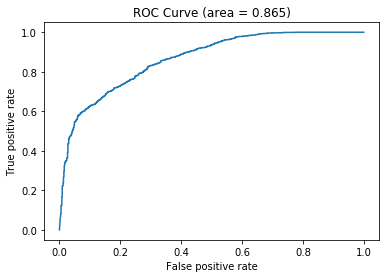

In [3]:
## Import Libraries ##
import keras
from keras.layers import Dense, Dropout, Activation
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from IPython.display import FileLink, FileLinks
import matplotlib.pyplot as plt
import pandas as pd
import sys
import pylab
from scipy.stats.stats import pearsonr

## List data files ##
datafilenames = ["Shared100NonShared/NormalizedCharge/output_final_1.h5","Shared100NonShared/AbsoluteCharge/output_final_1.h5",
                 "SharedHits/NormalizedCharge/output_final_1.h5","SharedHits/AbsoluteCharge/output_final_1.h5",
                "AllHits/NormalizedCharge/output_final_1.h5","AllHits/AbsoluteCharge/output_final_1.h5"]

## One image has 20x20 pixels = 400 pixels ##
pixels = ["pixel_{0}".format(i) for i in range(20*20)]
def to_image(df):
    return  np.expand_dims(np.expand_dims(df[pixels], axis=-1).reshape(-1,20,20), axis=-1)

## Import the data ##

datafilename = datafilenames[2]

df = pd.read_hdf("/uscms_data/d3/bbonham/TrackingDstar/LambaAnalyzer/output_of_postprocess/"+datafilename, key="df", mode='r')
print '\n \033[1m' + datafilename[:-18] + '\033[0m' # file name printed in bold
print df.info()
print ""

## Last cuts and selections. Eventually this should be moved to the postprocessor. ##
df = df[(df["GenDeltaR"]<0.1) & (df["nUniqueSimTracksInSharedHit"]>-1)] # this gets rid of shared hits as well

# Data set before removing single pixel events
df_old = df
df_old_train=df.sample(frac=0.5)
df_old_test=df.drop(df_old_train.index)
images_old_train = to_image(df_old_train)
images_old_test = to_image(df_old_test)

# Removing events that have single pixel
pixelColumns = ["pixel_%i" % x for x in range(400)]
pixels_df = df[pixelColumns].values
# This printout is a sanity check, there 400 pixels so we expect pixels_df to have 400 columns
#print(pixels_df[0].shape)
pixel_number = pixels_df.astype(bool).sum(axis=1)
df.insert(0, "Pixel_number", pixel_number)
# the df.info() printouts allows us to see how many events were removed.
#print df.info()
df = df[df["Pixel_number"]>1]
#print df.info()

## frac=0.5 sets half training and half testing ##
df_train = df.sample(frac=0.5)
df_test = df.drop(df_train.index)
images_train = to_image(df_train)
images_test = to_image(df_test)

## This is the CNN ##
# Adding layers to Neural Network: (1) is convolutional,(1.5) 2D layer ,(2) flatten output then feed it to (3) which is a regular neural network.
# (4) drops nodes in NN to avoid overfitting, finallly (5) outputs 2 values (prob(notmergedhit), prob(merged hit)), must add up to 1.

# Define the network
model = keras.models.Sequential()

# layer (1) you can play with these layers individually or together until you find the best combination
# Here at fnal you have to add input_shape and data_format in the first layer
model.add(keras.layers.Conv2D(32, kernel_size=(8,8), padding='same', activation='relu', input_shape=(20,20,1), data_format = "channels_last"))
model.add(keras.layers.Conv2D(32, kernel_size=(4,4), padding='same', activation='relu')) 
# layer (2)
model.add(keras.layers.Flatten(input_shape=(20,20,1))) # 20,20
# layer 2.5, dropout 10%
model.add(Dropout(0.1))
# layer (3)
model.add(keras.layers.Dense(100, activation='relu'))
#layer (4)
model.add(keras.layers.Dense(2, activation='softmax'))                                                
# Layer (5), train the network
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics = ["accuracy"]) 
# epochs: number of times you run the CNN.
epochs_number = 100
# early stopping callback: stops training early to prevent overtraining
early_stopping = EarlyStopping(monitor='val_loss', patience=10) 
# model checkpoint callback: this saves our model architecture + parameters into dense_model.h5
model_checkpoint = ModelCheckpoint('CNN_model.h5', monitor='val_loss', 
                                   save_best_only=True, 
                                   save_weights_only=False, mode='auto', 
                                   period=1)

# Train classifier
history = model.fit(images_train,
                    keras.utils.to_categorical(df_train["nUniqueSimTracksInSharedHit"]>1), 
                    epochs = epochs_number, 
                    callbacks=[early_stopping, model_checkpoint], 
                    validation_split=0.1) # fraction of training sample used for testing (here 10%)

# Plotting ROC Curve
ret = model.predict(images_test)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(keras.utils.to_categorical(df_test["nUniqueSimTracksInSharedHit"]>1)[:,1], ret[:,1])
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
auc = np.trapz(tpr_keras,fpr_keras)
plt.figure(1)
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve (area = {:.3f})'.format(auc))
plt.show()